# Quantum Machine Learning Exercies

In [1]:
import numpy as np
import seaborn as sns
import time

from matplotlib import pyplot as plt
from IPython.display import clear_output
from multiprocessing import Pool

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.datasets import load_iris, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import (
    ZFeatureMap,
    ZZFeatureMap
)
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler

## Support Vector Classifiers

We would like to compare the capabilities of classifying data using classical algorithms, compared to quantum algorithms. For our classical algorithm, we implement a __Support Vector Classifier (SVC)__. Recall, a SVC is a supervised learning classifier that finds a hyperplane using the kernel trick that correctly separates two classes with a maximum margin.

In [2]:
iris = load_iris()  # Dataset
X = iris.data  # 4 features x 150 samples (50 per 1 of 3 labels)
y = iris.target  # 3 labels

# Scale feature data to [0,1]
X = MinMaxScaler().fit_transform(X)

# Partition training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=123
)

# Create classifier and fit training data
svc = SVC(kernel="rbf", random_state=123)
svc.fit(X_train, y_train)

# Test performance of classical model
train_score_classical = svc.score(X_train, y_train)
test_score_classical = svc.score(X_test, y_test)
print(f"Classical SVC on the training dataset: {train_score_classical:.3f}")
print(f"Classical SVC on the test dataset:     {test_score_classical:.3f}")

Classical SVC on the training dataset: 0.992
Classical SVC on the test dataset:     0.967


#### Wow, so cool!

<Axes: >

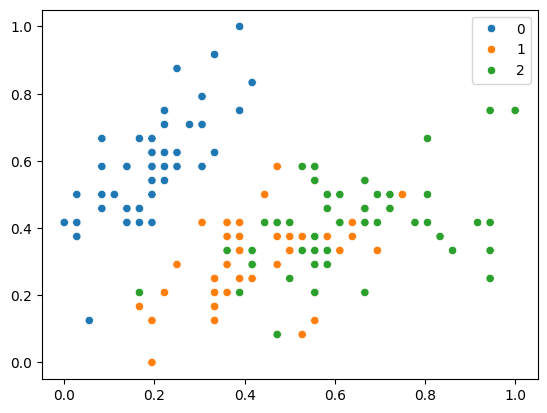

In [3]:
# Visualize the data
plt.clf()
plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="tab10")

## Quantum SVC

The __QSVC__ class within Qiskit serves as an extension to SVC from its Scikit-learn class. In order to use QSVC, we first need a kernel to equip it with. To define the kernel we require a feature map and a fidelity. The __fidelity__ would simply give an assessment of two quantum states when overlapping them. We require a __Sampler__ primitive for the fidelity, which supplies distributions for the circuit.

__Quantum Feature Maps__ are parameterized quantum circuits that encode the data.  The __ZZFeatureMap__ encodes interactions in the data according to the connectivity graph and the classical data map. The parameters we need to specify are how many features the data has, and how many repetitions we would like to apply. More repetitions lead to more entanglement.

In [4]:
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement="linear")
sampler = (
    Sampler()
)  # ComputeUncompute would define Sampler default; here for demonstration
fidelity = ComputeUncompute(sampler=sampler)  # combine circuit for comparison circuit
kernel = FidelityQuantumKernel(
    fidelity=fidelity, feature_map=feature_map
)  # classification kernel

#### Now we are ready to prepare and fit the classifier and obtain a score.

In [5]:
# Quantum SVC with quantum kernel
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(X_train, y_train)
qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC score: {qsvc_score}")

QSVC score: 0.9


#### How does this compare with implementing a classical SVC? And how would the quantum kernel act on the classical SVC if we were to evaluate it for use with SVC?

In [6]:
# Classical SVC with evaluated quantum kernel
matrix_train = kernel.evaluate(x_vec=X_train)
matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)

prec_svc = SVC(kernel="precomputed", random_state=123)
prec_svc.fit(matrix_train, y_train)
prec_score = prec_svc.score(matrix_test, y_test)

# Classical SVC with classical linear kernel
lin_svc = SVC(kernel="linear", random_state=123)
lin_svc.fit(X_train, y_train)
score = lin_svc.score(X_test, y_test)

# Print scores
print(f"Precomputed kernel SVC score: {prec_score}")
print(f"Linear SVC score: {score}")

Precomputed kernel SVC score: 0.9
Linear SVC score: 0.9333333333333333


#### Notice two things: <br>
(1) The QSVC score is the same as the precomputed SVC score, as it should be, since QSVC simply inherits SVC and they used the same kernel. <br>
(2) The linear SVC actually outperformed the QSVC. This is often the case currently as quantum kernels are still to improve a lot. For a large dataset, a quantum kernel might be evaluated much faster with reasonable accuracy, but for superior accuracy, classical kernels are still more accurate.

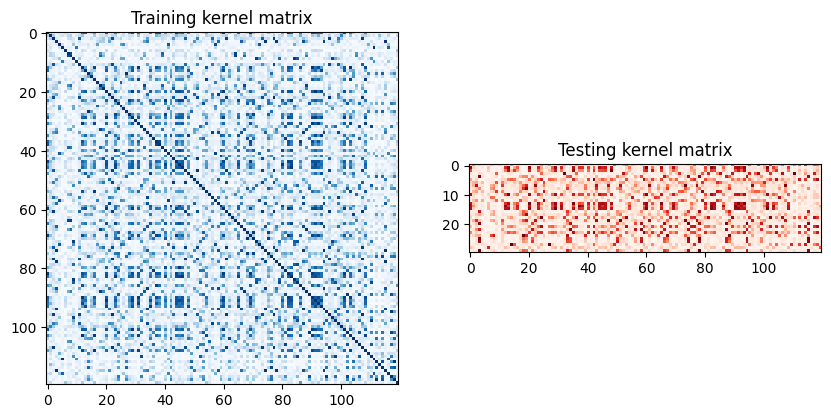

In [7]:
# Visualize the kernel matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
axs[1].imshow(
    np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds"
)
axs[1].set_title("Testing kernel matrix")
plt.show()

## Exercise 1:

Often it is useful to apply Principal Component Analysis (PCA) to reduce the amount of features for algorithms. This technique trades possibly weaker accuracy for faster computation and probably easier comprehension.

Use PCA to reduce the amount of features of the iris data to 2. Plot the reduced data points. Perform QSVC and SVC on the reduced data. Compare the two scores with each other and with the non-reduced QSVC and SVC scores. 

Useful methods are [__PCA__](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and __fit_transform__, and [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [ ]:
X_PCA = # PCA CODE

plt.clf()
plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], hue=y, palette="tab10");

In [9]:
# QSVC CODE

## Clustering

An example of unsupervised learning classification that can make use of quantum techniques is Clustering. Spectral clustering particularly groups data points into $n$ many 'clusters' by minimizing the sum-of-squares within each cluster. Compared to SVC, qiskit does not have a quantum analogous implementation, but evaluated quantum kernels can still be used on the classical algorithms. 

## Exercise 2

Create a quantum kernel, evaluate it, and apply it to a [SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) classifier to get a clustering score. Also implement a SpectralClustering classifier with the default kernel and get a clustering score. Compare and describe the two scores.

<Axes: >

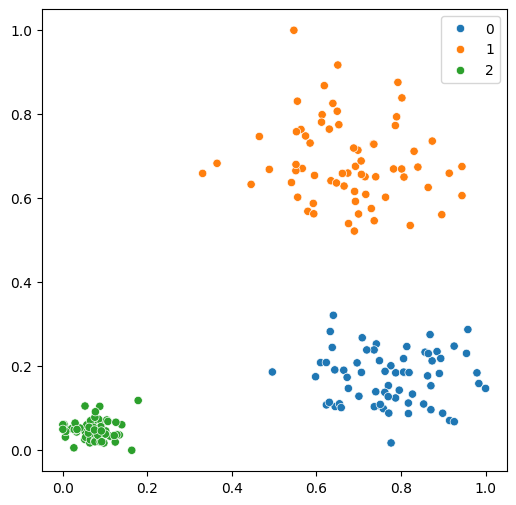

In [10]:
X, y = make_blobs(n_samples=200, cluster_std=[1.5, 2.0, 0.5], random_state=100)
X = MinMaxScaler().fit_transform(X)

plt.clf()
plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="tab10")

In [12]:
# Kernel and matrix CODE

In [13]:
# Clustering CODE

## Exercise 3

Create your own! Recall the fidelity kernel that was defined for QSVC above. It did a good job, but it could be better maybe. Especially if the score was low would we need a technique to improve the kernel. Quantum Kernel Alignment (QKA) does the trick to maximise the margin using a parameterized quantum kernel. 

[QuantumKernelTrainer](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.algorithms.QuantumKernelTrainer.html) class is used to train a quantum kernel. This involves the following steps:
1. Prepare the dataset.
2. Create a trainable layer of [parameters vector](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.ParameterVector) and define the feature map.
3. Set up an instance of `TrainableFidelityQuantumKernel` and an optimizer.
4. Set up an instance of `QuantumKernelTrainer` and use the `QuantumKernelTrainer.fit` method to train the kernel parameters on the dataset.
6. Pass the trained quantum kernel to a machine learning model and use the model to do the further training.

In [14]:
# importing required packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer

In [15]:
# Prepare the dataset
# For this example, we will use the Iris dataset and perform PCA.

iris = load_iris()
X = iris.data
y = iris.target

X = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=123
)

# reduce the number of features to two.
X_PCA = PCA(n_components=2).fit_transform(X)

pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(
    X_PCA, y, train_size=0.8, random_state=123
)

# Create a trainable layer of parameters
# NOTE: the number of registers in the quantum circuit below should be equal \
# to the number of features in the data above
training_parameter = ParameterVector("θ", 1)
qc_with_parameters = QuantumCircuit(2)

# An example of adding parameter to the quantum circuit.
# NOTE: Other quantum gates can also be used.
qc_with_parameters.ry(training_parameter[0], 0)
qc_with_parameters.rx(training_parameter[0], 1)

# Define the feature map
repetitions = 1
entanglement = "full"
feature_map = ZZFeatureMap(2, reps=repetitions, entanglement=entanglement)

parametrized_feature_map = qc_with_parameters.compose(feature_map)

# Use the following function to visualize the "composed" circuit.
# print(circuit_drawer(fm))

# Instantiate the trainable quantum kernel with feature map and training parameter
trainable_quantum_kernel = TrainableFidelityQuantumKernel(
    feature_map=parametrized_feature_map, training_parameters=training_parameter
)

# Set up the optimizer
maxiter = 1
lr = None
perturbation = None
optimizer = SPSA(maxiter=maxiter, learning_rate=lr, perturbation=perturbation)

# Instantiate a quantum kernel trainer.
loss = "svc_loss"
initial_point = [np.pi / 2]
qkt = qkt = QuantumKernelTrainer(
    quantum_kernel=trainable_quantum_kernel,
    loss="svc_loss",
    optimizer=optimizer,
    initial_point=initial_point,
)

# Train the kernel using QKT directly
qka_results = qkt.fit(pca_X_train, pca_y_train)
optimized_kernel = qka_results.quantum_kernel

# Use the trained kernel in QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC and calculate the score
qsvc.fit(pca_X_train, pca_y_train)

qsvc_score = qsvc.score(pca_X_test, pca_y_test)

print(f"QSVC score: {qsvc_score}")

QSVC score: 0.8333333333333334
